In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
# import torchsummary

import sys
import itertools
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
stdout = sys.stdout

In [78]:
print(device)

cuda


In [79]:
# model architecture and training

class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_one = nn.Linear(
            in_features=kwargs["input_width"], 
            out_features=kwargs["hidden_width"], 
            bias=kwargs["bias"]
        )
        self.encoder_two = nn.Linear(
            in_features=kwargs["hidden_width"], 
            out_features=kwargs["code_width"], 
            bias=kwargs["bias"]
        )
        
        self.decoder_one = nn.Linear(
            in_features=kwargs["code_width"], 
            out_features=kwargs["hidden_width"], 
            bias=kwargs["bias"]
        )
        
        self.decoder_two = nn.Linear(
            in_features=kwargs["hidden_width"], 
            out_features=kwargs["input_width"], 
            bias=kwargs["bias"]
        )
        
        if kwargs['linear']:
            self.activation = lambda x: x
        else:
            self.activation = F.relu

    def forward(self, x):
        shape = x.shape
        x = torch.flatten(x, start_dim=1)
        x = self.activation(self.encoder_one(x))
        x = self.activation(self.encoder_two(x))
        x = self.activation(self.decoder_one(x))
        x = self.activation(self.decoder_two(x))
        x = torch.reshape(x, shape)
        return x
    
    
def train(model, epochs, train_loader, optimizer, criterion, verbose=True):
    for epoch in range(epochs):
        model.train()
        loss = torch.zeros((), device = device)
        
        for data in train_loader:
            batch_features, _ = data
            batch_features = batch_features.to(device)
            optimizer.zero_grad()

            outputs = model(batch_features)
            train_loss = criterion(outputs, batch_features)
            train_loss.backward()
            optimizer.step()
            loss += train_loss.item()

        loss = loss / len(train_loader)
        if verbose:
            print("{};{:.6f}".format(epoch + 1, loss))
    return model

training samples: 60000
loader length: 60


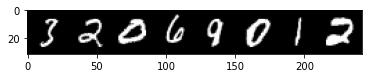

In [80]:
# load and visualize the data

set0 = tv.datasets.MNIST("../MNIST/", 
                         download=True, 
                         train = True,
                         transform = tv.transforms.ToTensor())
loader0 = torch.utils.data.DataLoader(set0, 
                                     batch_size = 1000, 
                                     shuffle = True)
print("training samples: " + str(len(set0)) + 
     "\nloader length: " + str(len(loader0)))

def imshow(img):
    npimg = img.numpy()
    plt.imshow((np.transpose(npimg, (1, 2, 0))*255).astype(np.uint8))

dataiter = iter(loader0)
image, _ = dataiter.next()

imshow(tv.utils.make_grid(image[:8]))
plt.show()

In [81]:
# hyperparams

params = {
    # data    
    "input_width": 28*28, 
    
    # model
    "linear":False,
    "bias": False,
    "code-range": [1,2,5,10],
    "hide-range": [10,20,50,100,200,500],
    
    # training
    "lr": 1e-3,
    "epochs": 50
}

In [82]:
# train models

models_trained = {(x,y): None for x,y in zip(params['code-range'],params['hide-range'])}

for code_width in params['code-range']:
    for hidden_width in params['hide-range']:
        model = AE(**params,
                   **{"code_width":code_width, 
                      "hidden_width":hidden_width}
                ).to(device)
        opt = optim.Adam(model.parameters(), lr=params['lr'])
        crit = nn.MSELoss(reduction='mean')
        
        print("{};{}".format(code_width,hidden_width))
        
        sys.stdout = open("log/AE-" + str(code_width) + 
                          "-" + str(hidden_width) + 
                          ".txt", "w")
        
        models_trained[code_width,hidden_width] = train(model, 
                                                        params["epochs"], 
                                                        loader0, 
                                                        opt, 
                                                        crit).to('cpu')
        
        sys.stdout.close()
        sys.stdout = stdout

1;10
1;20
1;50
1;100
1;200
1;500
2;10
2;20
2;50
2;100
2;200
2;500
5;10
5;20
5;50
5;100
5;200
5;500
10;10
10;20
10;50
10;100
10;200
10;500


In [87]:
# save results

for code_width in params['code-range']:
    for hidden_width in params['hide-range']:
        torch.save(models_trained[code_width, hidden_width].state_dict(), 
                   "models/AE-" + str(code_width) + "-" + str(hidden_width))


original:


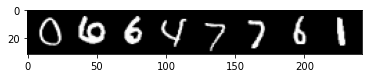

code width:1


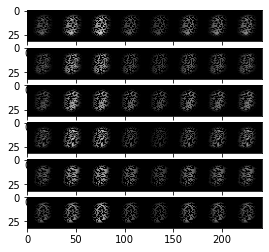

code width:2


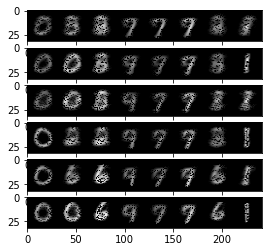

code width:5


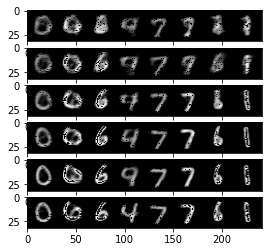

code width:10


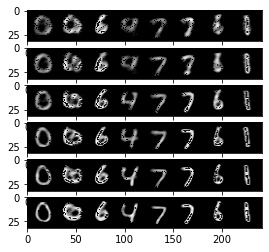

In [86]:
# visualise the results - encoded image

image, _ = dataiter.next()

print("original:")
imshow(tv.utils.make_grid(image[:8]))
plt.show()

for code_width in params['code-range']:
    print("code width:" + str(code_width))
    fig = plt.figure(figsize = (7,4) )
    i=1
    
    for hidden_width in params['hide-range']:
        res = models_trained[code_width,hidden_width](image[:8])
        fig.add_subplot(len(params['hide-range']), 1, i)
        imshow(tv.utils.make_grid(res.detach()))
        i+=1
        
    plt.savefig("plots/AE-image-" + str(code_width) + ".png")
    plt.show()

code width:1


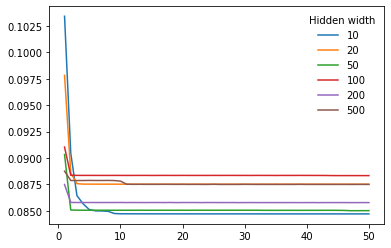

code width:2


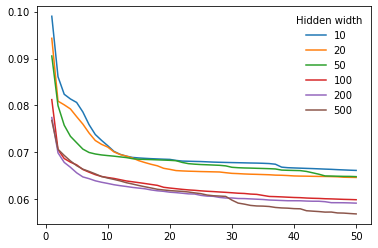

code width:5


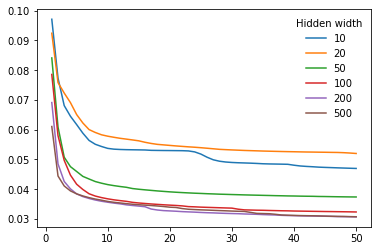

code width:10


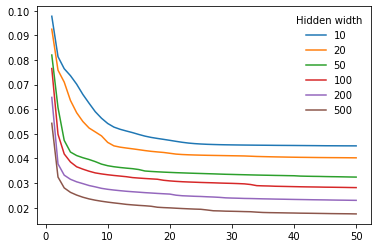

In [84]:
# plot the convergence

for code_width in params['code-range']:
    print("code width:" + str(code_width))
    
    for hidden_width in params['hide-range']:
        with open('log/AE-' + str(code_width) + '-' + 
                  str(hidden_width) + '.txt') as f:
            lines = f.readlines()
            x = [int(line.split(";")[0]) for line in lines]
            y = [float(line.split(";")[1]) for line in lines]
            plt.plot(x, y, label = hidden_width)
    
    plt.legend(loc="upper right", title="Hidden width", frameon=False)
    plt.savefig("plots/AE-conv-" + str(code_width) + ".png")
    plt.show()